In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import scikit_posthocs as sp
import math
import seaborn as sns
from scikit_posthocs import posthoc_dunn
import openpyxl
import random
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
import pingouin
import seaborn as sb
import warnings
from scipy.stats import gaussian_kde
from statsmodels.tsa.stattools import grangercausalitytests
import calendar
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX

Loading dataset.

In [2]:
data = pd.read_csv('water_quality_data.csv')

In [4]:
data.head(10)

,Year,Month,Province,Catchment,River,Sampling Point,BOD,COD,DO,pH,...,PO4,SO4,TH,Zn,TDS,TSS,Alk,PV,Mn,Ni
0,2017,January,Mashonaland East,Mazowe,Rufaro tributary,DR26,6.618625,45.0,62.150000,7.63,...,0.791775,3.929751,46.64194,0.01,156.0,18.0,49.3,3.53,0.01,0.01
1,2017,January,Mashonaland East,Mazowe,Ruzawi,DR49,6.555708,36.0,71.141667,7.50,...,0.174530,3.285518,58.25238,0.01,154.0,20.0,49.9,1.21,0.01,0.01
2,2017,January,Mashonaland East,Mazowe,Wenimbi dam,DR50,5.129778,31.0,66.760000,7.43,...,0.099356,4.639778,55.85022,0.01,162.0,4.0,50.1,0.10,0.01,0.01
3,2017,January,Mashonaland East,Mazowe,Save,DR51,4.937111,56.0,70.542857,8.37,...,0.058958,3.559660,58.05220,0.01,296.0,18.0,72.3,3.43,0.01,0.01
4,2017,January,Mashonaland East,Mazowe,Nyoka,DR52,5.143479,57.0,64.446154,7.59,...,0.055762,3.902337,45.64104,0.01,172.0,70.0,34.2,2.34,0.01,0.01
5,2017,January,Mashonaland East,Mazowe,Chirume,DR53,7.619421,47.0,72.864286,7.56,...,0.061125,3.833802,41.23708,0.01,220.0,92.0,66.8,0.62,0.01,0.01
6,2017,January,Midlands,Runde,Runde,DER14,5.695000,57.0,81.300000,7.32,...,0.431725,51.054691,85.07650,0.01,318.0,6.0,148.8,0.10,0.01,0.01
7,2017,January,Midlands,Sanyati,Gweru,DCR115,9.024286,48.0,45.900000,7.43,...,0.562650,92.237612,165.14850,0.01,378.0,8.0,225.3,4.87,0.32,0.01
8,2017,January,Midlands,Sanyati,Kwekwe,DCL1,4.975185,35.0,76.940000,7.24,...,0.142402,17.129669,56.85112,0.01,198.0,62.0,64.3,0.10,0.11,0.01
9,2017,January,Midlands,Runde,Ngamo,DAL8,7.871852,51.0,70.460000,7.83,...,0.033019,4.176479,45.84122,0.01,206.0,14.0,85.9,2.72,0.01,0.01


Various strengths of the method specified for the imputation of missing values in water quality data are given below.

Strengths
1. Hierarchical Imputation: 
Contextual Relevance: The methodology, based on moving averages according to sampling point, river, and catchment, maintains the contextual relevance of the data, leading to more accurate imputations.

3. Flexibility: The method allows for multiple levels of imputation so that if higher-level context-for example, sampling point-is unavailable, then it can fall back to broader contexts, such as river or catchment.

4. Preserving Data Structure
The imputation maintains the original data structure and enables downstream analyses without introducing significant biases.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24026 entries, 0 to 24025
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            24026 non-null  int64  
 1   Month           24026 non-null  object 
 2   Province        24026 non-null  object 
 3   Catchment       24026 non-null  object 
 4   River           24026 non-null  object 
 5   Sampling Point  24026 non-null  object 
 6   BOD             24026 non-null  float64
 7   COD             24026 non-null  float64
 8   DO              24026 non-null  float64
 9   pH              24026 non-null  float64
 10  NTU             24026 non-null  float64
 11  CL              24026 non-null  float64
 12  Cu              24026 non-null  float64
 13  EC              24026 non-null  float64
 14  Fe              24026 non-null  float64
 15  NO3             24026 non-null  float64
 16  PO4             24026 non-null  float64
 17  SO4             24026 non-null 

In [4]:
#checking percentage of missing values per column
missing_percentage = data.iloc[:,0:26].isnull().sum()/len(data)*100
print(missing_percentage)

Year              0.0
Month             0.0
Province          0.0
Catchment         0.0
River             0.0
Sampling Point    0.0
BOD               0.0
COD               0.0
DO                0.0
pH                0.0
NTU               0.0
CL                0.0
Cu                0.0
EC                0.0
Fe                0.0
NO3               0.0
PO4               0.0
SO4               0.0
TH                0.0
Zn                0.0
TDS               0.0
TSS               0.0
Alk               0.0
PV                0.0
Mn                0.0
Ni                0.0
dtype: float64


For some parameters, testing was stopped in 2016 due to several reasons. So from there available measurements are a bias. So on analyses for these parameters, they are only analyzed for that period of time.

In [3]:
# List of parameters
parameters = ["BOD", "COD", "DO", 'pH', "NTU", "CL", "EC", "Fe", "Zn", 
              "NO3", "PO4", 'TH', 'SO4', 'TSS', "Mn", 'TDS', "Alk", 'PV', 
              'Cu', 'Ni']

In [4]:
# Define limited parameters(these are parameters that were only tested until december 2016)
limited_parameters = ['TH', 'SO4', 'TSS', 'TDS', 'Alk', 'Zn', 'PV', 'Cu', 'Ni']

In [5]:
#these ones have full continuous data
unlimited_parameters = ['BOD', 'COD', 'DO', 'pH', 'NTU', 'CL', 'EC', 'Fe', 'NO3', 'PO4', 'Mn']

In [6]:
# Filter the DataFrame for years less than 2017
filtered_data = data[data['Year'] < 2017]

In [9]:
# Use describe() on the filtered data for the limited parameters
description = filtered_data[limited_parameters].describe()

# Output the description
print(description)

                TH          SO4          TSS           TDS          Alk  \
count  9850.000000  9850.000000  9850.000000   9850.000000  9850.000000   
mean    131.581534    49.937601    40.538822    262.148102   129.703147   
std     191.516383   305.248401   130.358898    626.782660   122.610560   
min       0.100000     1.000000     1.000000      1.000000     1.000000   
25%      52.447160     1.000000     1.000000     86.000000    49.900000   
50%      88.879920     6.908392    10.000000    166.000000    87.000000   
75%     157.541660    17.021877    32.000000    298.000000   162.075000   
max    5835.847540  6584.305430  3760.000000  21152.000000   993.300000   

                Zn           PV           Cu           Ni  
count  9850.000000  9850.000000  9850.000000  9850.000000  
mean      0.014783     6.047596     0.018781     0.027659  
std       0.046175    11.943828     0.198710     0.106709  
min       0.010000     0.100000     0.010000     0.010000  
25%       0.010000     0

In [10]:
# Use describe() on the filtered data for the unlimited parameters
description2 = data[unlimited_parameters].describe()

# Output the description
print(description2)

                BOD           COD            DO            pH           NTU  \
count  24026.000000  24026.000000  24026.000000  24026.000000  24026.000000   
mean       7.872577     57.446136     62.813190      7.594370     33.682506   
std        9.286463     84.459374     18.439182      0.649142     64.578720   
min        2.000000      1.390000      5.000000      2.260000      1.000000   
25%        2.000000     25.000000     54.981250      7.290000      5.220000   
50%        3.370000     33.254000     66.400000      7.640000     12.500000   
75%       10.256667     50.450000     75.425926      7.960000     33.500000   
max       81.816667   1450.000000     94.000000      9.940000    974.000000   

                CL            EC            Fe           NO3           PO4  \
count  24026.00000  24026.000000  24026.000000  24026.000000  24026.000000   
mean      64.31480    378.237764      1.018083      0.853288      0.507560   
std       58.71871    448.810824      6.402469      2.

Histograms and boxplots. helps in dertemining distribution.

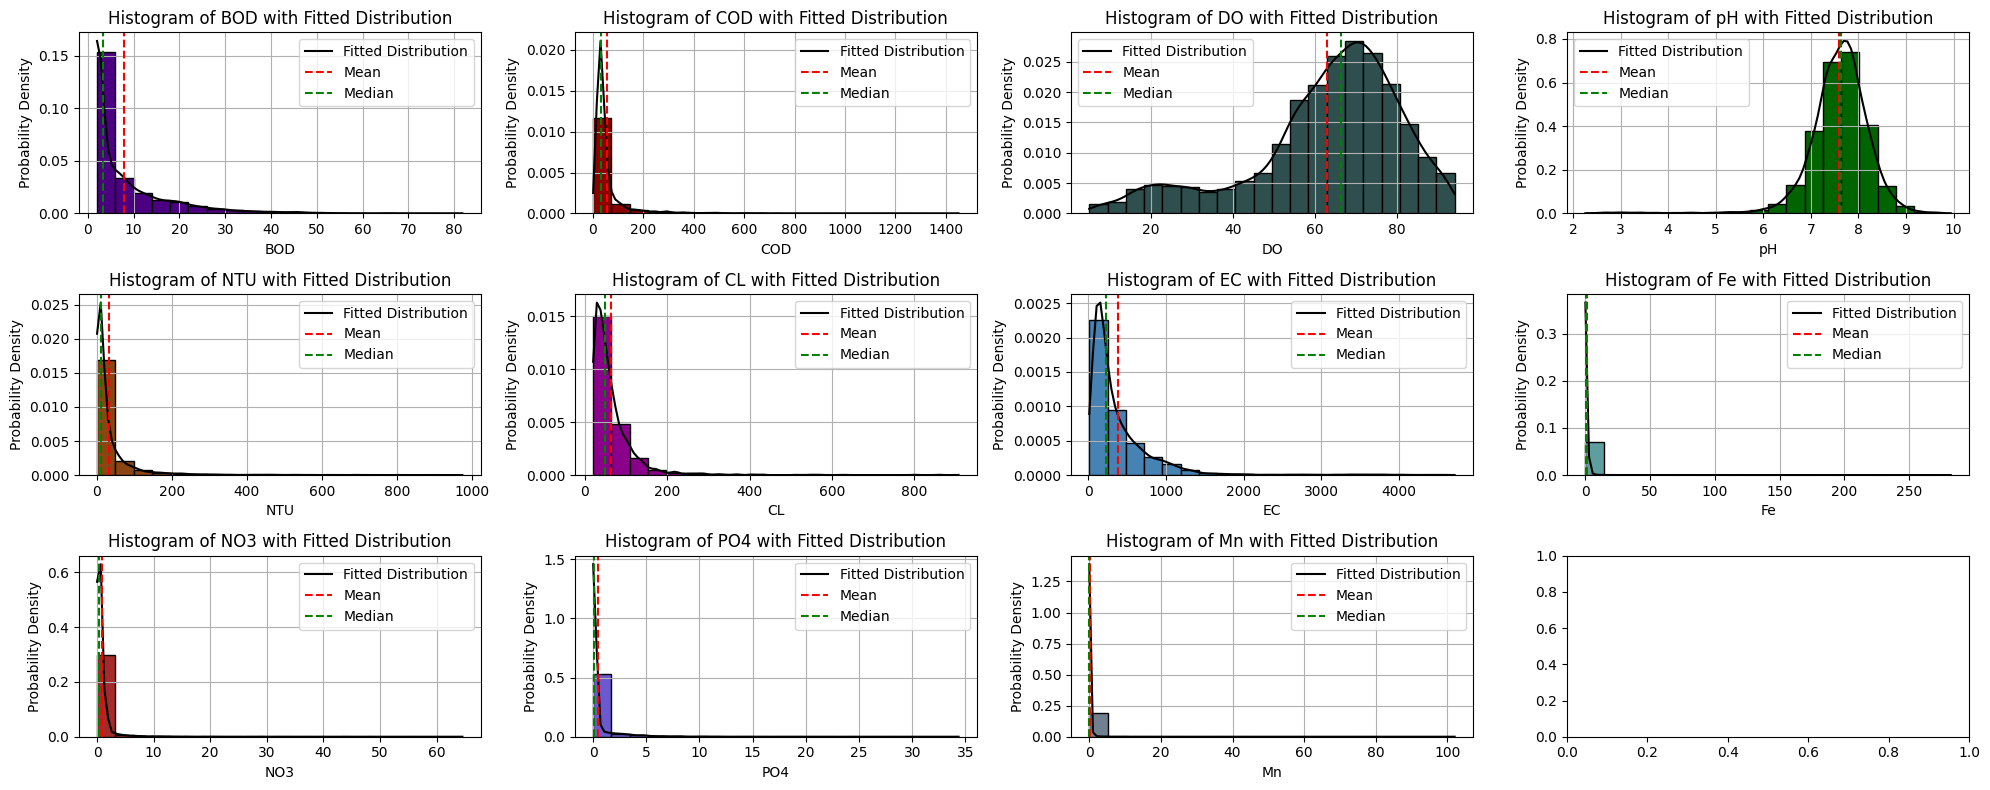

In [11]:
# Create subplots for each parameter
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 8))

# Parameters and corresponding subplot indexes
indexes = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]

# Define colors for each plot
colors = ['#4B0082', '#8B0000', '#2F4F4F', '#006400', '#8B4513', '#8B008B', 
          '#4682B4', '#5F9EA0', '#A52A2A', '#6A5ACD', '#708090', '#556B2F',
          '#FF4500', '#7B68EE', '#2E8B57', '#8B0000', '#4682B4', '#6B8E23', 
          '#D2691E', '#CD5C5C']

# Iterate over parameters and indexes
for param, idx, color in zip(unlimited_parameters, indexes, colors):
    # Select the corresponding subplot
    ax = axes[idx]

    # Create a histogram of the parameter
    ax.hist(data[param], bins=20, color=color, edgecolor='black', density=True)

    # Fit a kernel density estimation to the data
    kde = gaussian_kde(data[param].dropna())

    # Create an array of values within the range of the parameter data
    x = np.linspace(data[param].min(), data[param].max(), 100)

    # Calculate the corresponding probability density function (PDF) values
    pdf = kde.evaluate(x)

    # Plot the fitted distribution line
    ax.plot(x, pdf, color='black', label='Fitted Distribution')

    # Add grid lines
    ax.grid(True)

    # Add mean and median lines
    ax.axvline(data[param].mean(), color='red', linestyle='dashed', linewidth=1.5, label='Mean')
    ax.axvline(data[param].median(), color='green', linestyle='dashed', linewidth=1.5, label='Median')

    # Add labels and title for each subplot
    ax.set_xlabel(param)
    ax.set_ylabel('Probability Density')
    ax.set_title(f'Histogram of {param} with Fitted Distribution')

    # Show legend for each subplot
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the image with all histograms and fitted distribution lines
plt.show()

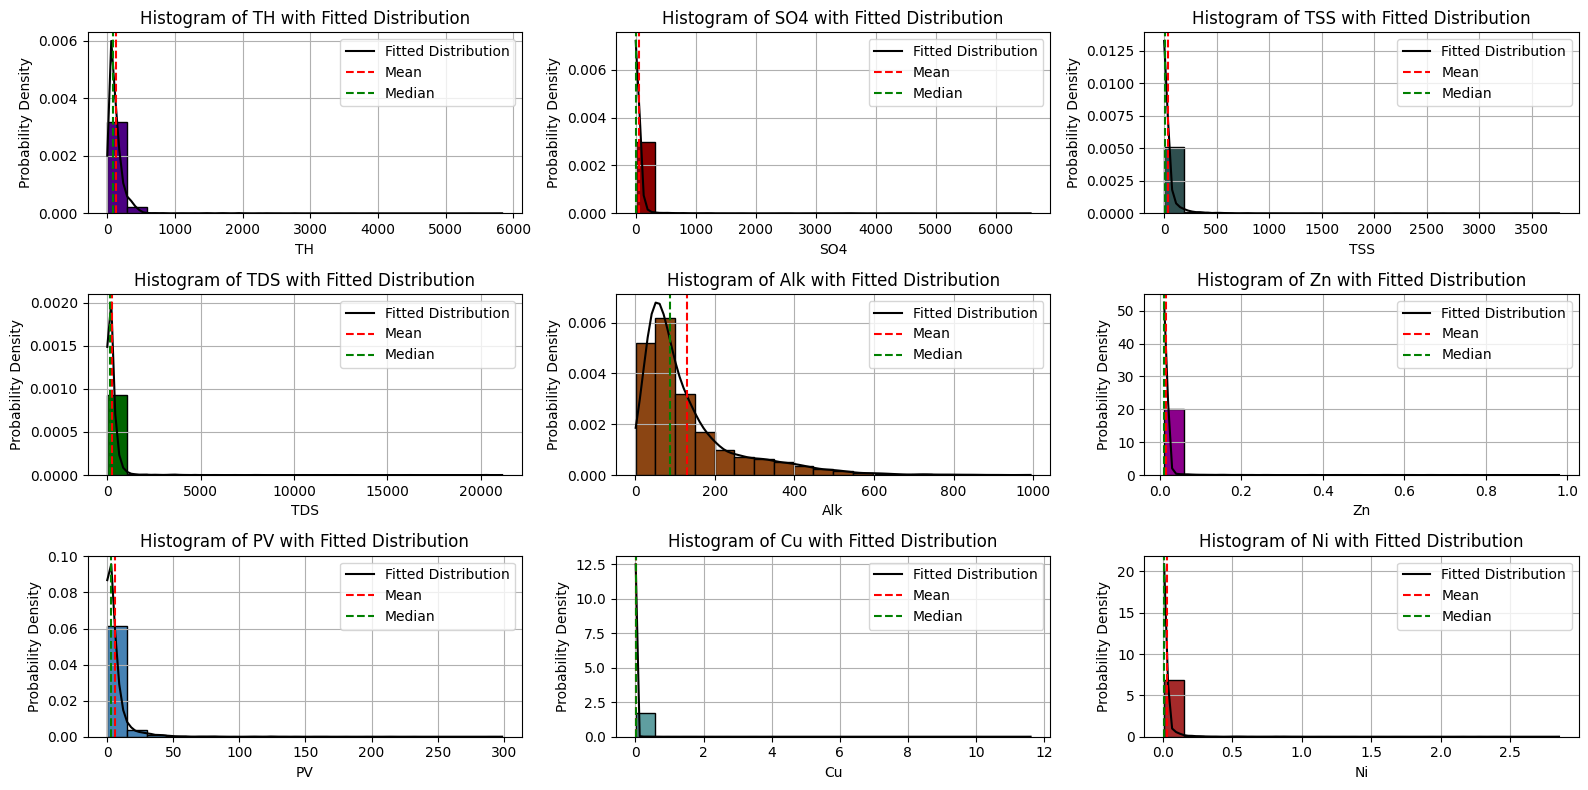

In [12]:
# Create subplots for each limited parameter
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))

# Corresponding subplot indexes for limited parameters
indexes = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

# Define colors for each plot
colors = ['#4B0082', '#8B0000', '#2F4F4F', '#006400', '#8B4513', 
          '#8B008B', '#4682B4', '#5F9EA0', '#A52A2A']

# Iterate over limited parameters and indexes
for param, idx, color in zip(limited_parameters, indexes, colors):
    # Select the corresponding subplot
    ax = axes[idx]

    # Create a histogram of the parameter
    ax.hist(filtered_data[param], bins=20, color=color, edgecolor='black', density=True)

    # Fit a kernel density estimation to the data
    kde = gaussian_kde(filtered_data[param].dropna())

    # Create an array of values within the range of the parameter data
    x = np.linspace(filtered_data[param].min(), filtered_data[param].max(), 100)

    # Calculate the corresponding probability density function (PDF) values
    pdf = kde.evaluate(x)

    # Plot the fitted distribution line
    ax.plot(x, pdf, color='black', label='Fitted Distribution')

    # Add grid lines
    ax.grid(True)

    # Add mean and median lines
    ax.axvline(filtered_data[param].mean(), color='red', linestyle='dashed', linewidth=1.5, label='Mean')
    ax.axvline(filtered_data[param].median(), color='green', linestyle='dashed', linewidth=1.5, label='Median')

    # Add labels and title for each subplot
    ax.set_xlabel(param)
    ax.set_ylabel('Probability Density')
    ax.set_title(f'Histogram of {param} with Fitted Distribution')

    # Show legend for each subplot
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the image with all histograms and fitted distribution lines
plt.show()

boxplots.

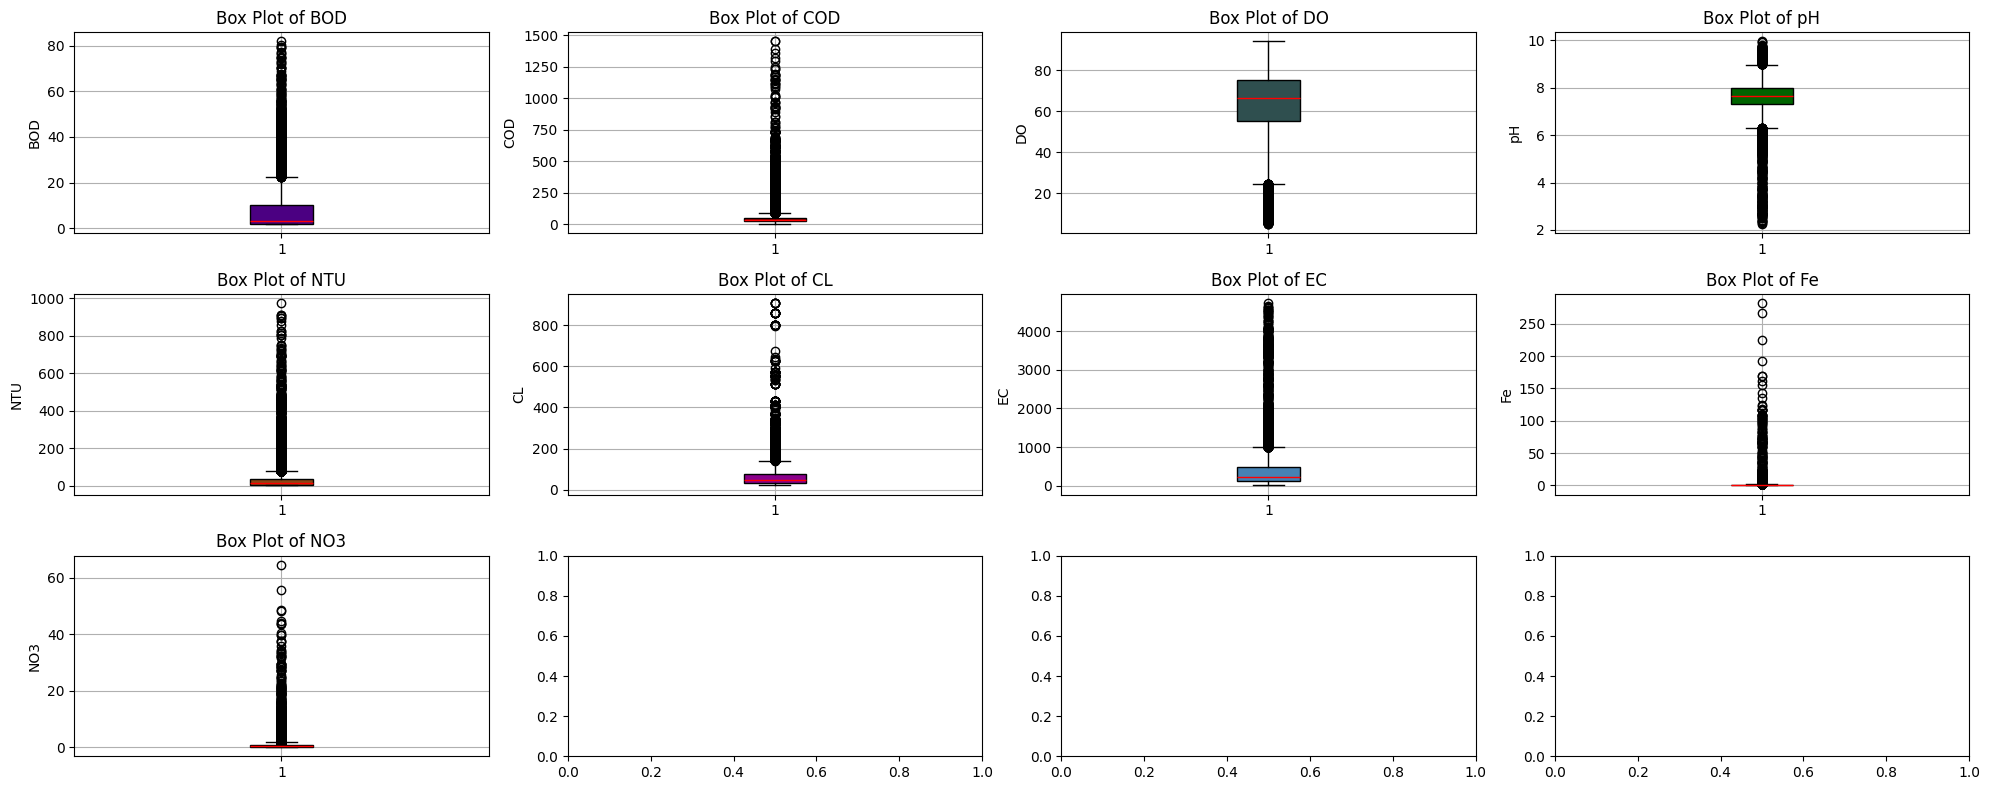

In [13]:
# Create subplots for each parameter
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 8))

indexes = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]

# Iterate over parameters and indexes
for param, idx, color in zip(unlimited_parameters, indexes, colors):
    ax = axes[idx]

    # Create a box plot of the parameter
    ax.boxplot(data[param], patch_artist=True, boxprops=dict(facecolor=color, color='black'),
               medianprops=dict(color='red'), whiskerprops=dict(color='black'), capprops=dict(color='black'))

    # Add grid lines
    ax.grid(True)

    # Add labels and title for each subplot
    ax.set_ylabel(param)
    ax.set_title(f'Box Plot of {param}')

# Adjust spacing between subplots
plt.tight_layout()

# Display the image with all box plots
plt.show()

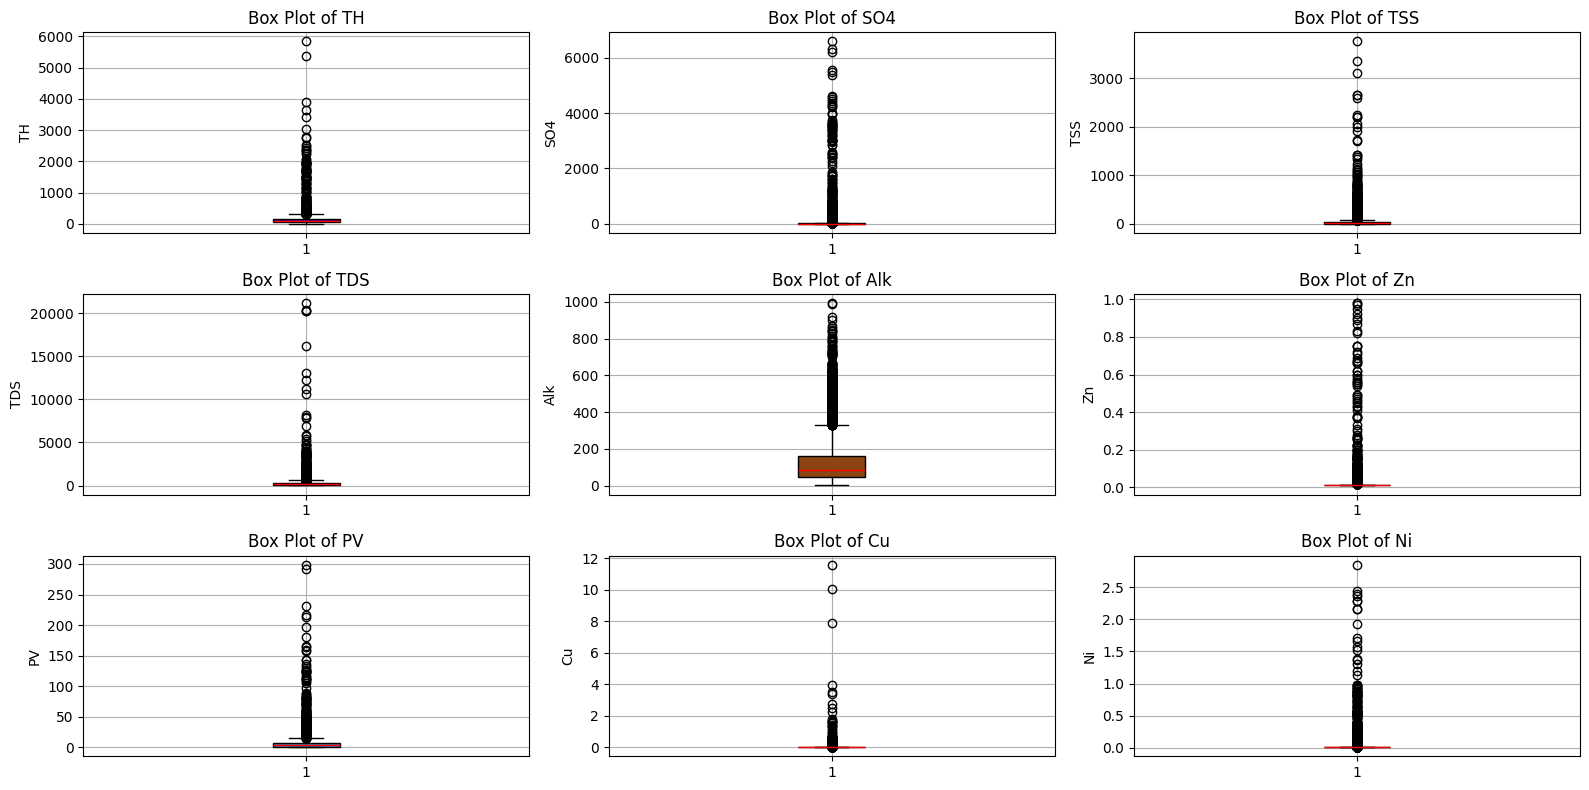

In [14]:
# Create subplots for each limited parameter
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))

indexes = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

# Define colors for each plot
colors = ['#4B0082', '#8B0000', '#2F4F4F', '#006400', '#8B4513', 
          '#8B008B', '#4682B4', '#5F9EA0', '#A52A2A']

# Iterate over limited parameters and indexes
for param, idx, color in zip(limited_parameters, indexes, colors):
    ax = axes[idx]

    # Create a box plot of the parameter
    ax.boxplot(filtered_data[param], patch_artist=True,
               boxprops=dict(facecolor=color, color='black'),
               medianprops=dict(color='red'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'))

    # Add grid lines
    ax.grid(True)

    # Add labels and title for each subplot
    ax.set_ylabel(param)
    ax.set_title(f'Box Plot of {param}')

# Adjust spacing between subplots
plt.tight_layout()

# Display the image with all box plots
plt.show()

We can conclude that these parameters are non-parametric therefore non-parametric analyses can be considered,these are statistical methods that do not underline any assumption of normal
ity.Although pH and DO might look like they are normally distributed, they are a bit skewed, confirmed using visual presentations.

Correlation analysis.

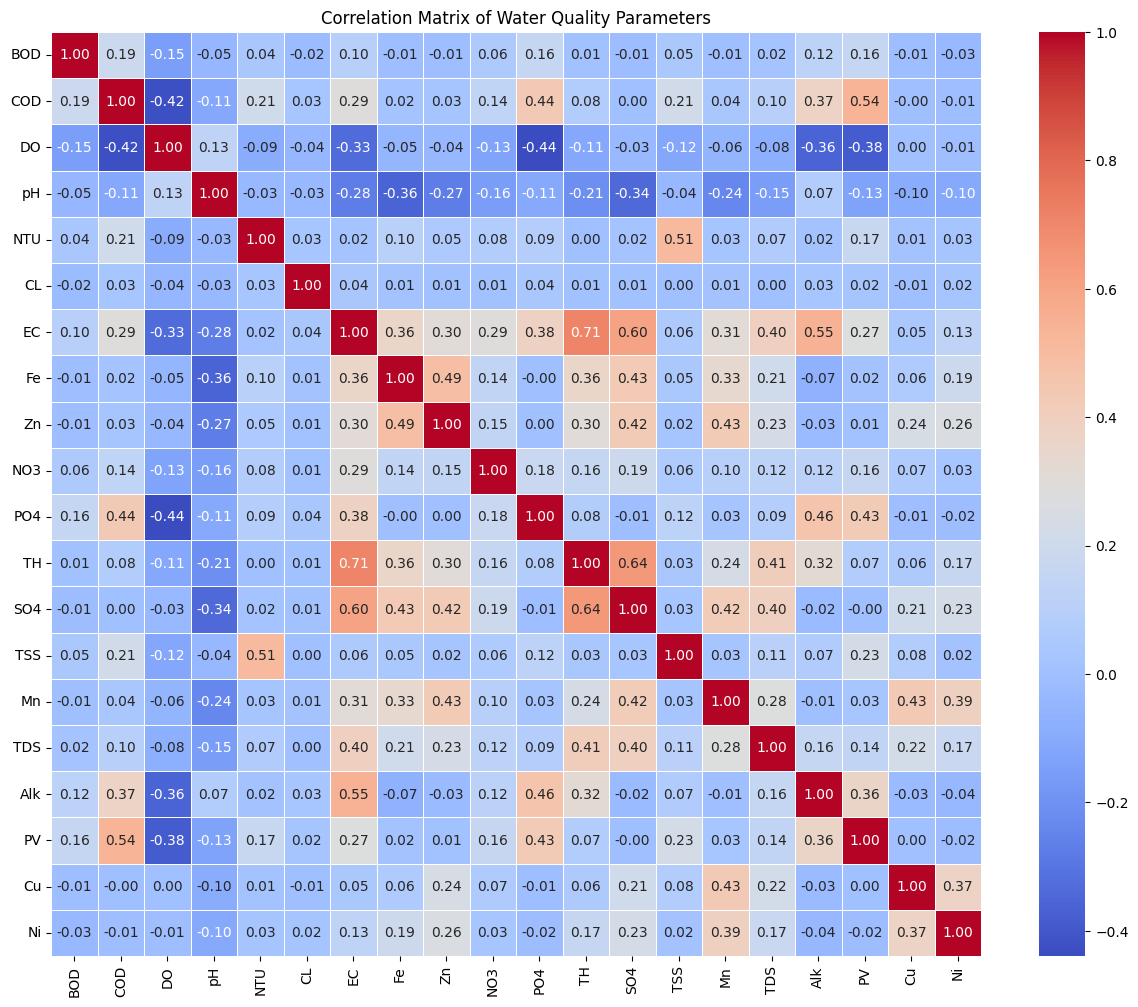

In [15]:
# Create a subset of the data with the relevant columns
water_quality_subset = data[parameters]

# Check if any of the columns are in the limited parameters
if any(param in water_quality_subset.columns for param in limited_parameters):
    # Filter the data for years less than 2017 if at least one limited parameter is present
    filtered_data = data[data['Year'] < 2017]
    water_quality_subset = filtered_data[parameters]
else:
    # If no limited parameters are present, use the original data
    water_quality_subset = water_quality_subset

# Convert the selected columns to float
#water_quality_subset = water_quality_subset.apply(pd.to_numeric, errors='coerce')

# Calculate the correlation matrix
correlation_matrix = water_quality_subset.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Water Quality Parameters")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

INTERPRETATION OF THE ABOVE MATRIX

The correlation coefficient ranges from -1 to 1.
A value of -1 indicates a perfect negative correlation, meaning that as one variable increases, the other variable decreases linearly.
A value of 1 indicates a perfect positive correlation, meaning that as one variable increases, the other variable also increases linearly.
A value of 0 indicates no linear correlation between the variables.

Magnitude of the Correlation Coefficient:
The closer the correlation coefficient is to -1 or 1, the stronger the relationship between the variables.
A correlation coefficient close to 0 suggests a weak or no linear relationship between the variables.

Checking for stationarity before causality analysis and time series analysis.

In [16]:
# Create a subset of the data with the relevant columns
water_quality_subset = data[parameters]

# Check if any of the columns are in the limited parameters
if any(param in water_quality_subset.columns for param in limited_parameters):
    # Filter the data for years less than 2017 if at least one limited parameter is present
    filtered_data = data[data['Year'] < 2017]
    water_quality_subset = filtered_data[parameters]

else:
    water_quality_subset = water_quality_subset

# Prepare a DataFrame to store stationarity test results
stationarity_results = pd.DataFrame(columns=['Variable', 'ADF Statistic', 'p-value', 'Stationary'])

# Perform ADF test for each parameter
for column in water_quality_subset.columns:
    adf_result = adfuller(water_quality_subset[column].dropna())
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    is_stationary = p_value < 0.05  # Stationarity if p-value < 0.05
    stationarity_results = pd.concat([stationarity_results, pd.DataFrame({
        'Variable': [column],
        'ADF Statistic': [adf_statistic],
        'p-value': [p_value],
        'Stationary': [is_stationary]
    })], ignore_index=True)

# Display the results
print(stationarity_results)

C:\Users\BIGSAM TECH\AppData\Local\Temp\ipykernel_11820\3945894541.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stationarity_results = pd.concat([stationarity_results, pd.DataFrame({


   Variable  ADF Statistic       p-value Stationary
0       BOD     -10.066776  1.290050e-17       True
1       COD     -28.917431  0.000000e+00       True
2        DO     -11.148996  2.976200e-20       True
3        pH      -7.765539  9.209481e-12       True
4       NTU      -9.675874  1.241263e-16       True
5        CL     -29.364586  0.000000e+00       True
6        EC     -22.624362  0.000000e+00       True
7        Fe     -36.150922  0.000000e+00       True
8        Zn     -29.990629  0.000000e+00       True
9       NO3     -35.031900  0.000000e+00       True
10      PO4     -23.864885  0.000000e+00       True
11       TH     -33.328445  0.000000e+00       True
12      SO4     -55.639827  0.000000e+00       True
13      TSS     -11.976737  3.786410e-22       True
14       Mn     -53.412611  0.000000e+00       True
15      TDS     -25.436229  0.000000e+00       True
16      Alk     -26.959261  0.000000e+00       True
17       PV     -30.389731  0.000000e+00       True
18       Cu 

All parameters are stationary.

Proceeding to granger causality.

In [18]:
# Define pairs of parameters to analyze
parameter_pairs = [
    ('EC', 'TH'),
    ('EC', 'SO4'),
    ('COD', 'PV'),
    ('Alk', 'EC'),
    ('TDS', 'TH'),
    ('Mn', 'Zn'),
    ('NO3', 'PO4'),
    ('BOD', 'DO'),
    ('BOD', 'PV')
]

max_lag = 5  # Set the maximum lag to test

# Iterate over each parameter pair
for param1, param2 in parameter_pairs:
    # Filter data based on conditions
    if param1 in limited_parameters or param2 in limited_parameters:
        data_filtered = data[data['Year'] < 2017]
    else:
        data_filtered = data  # No filtering for other parameters

    # Select the parameters to analyze
    test_data = data_filtered[[param1, param2]]

    # Perform Granger Causality Test
    test_result = grangercausalitytests(test_data, max_lag, verbose=False)

    # Print labeled results for each lag
    print(f'Results for {param1} vs {param2}:')
    for lag in range(1, max_lag + 1):
        f_stat = test_result[lag][0]['ssr_ftest'][0]
        p_value = test_result[lag][0]['ssr_ftest'][1]
        print(f'  Lag {lag}: F-statistic = {f_stat:.4f}, P-value = {p_value:.4f}')
    print('\n')  # Add a newline for better separation between pairs

c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Results for EC vs TH:
  Lag 1: F-statistic = 85.9880, P-value = 0.0000
  Lag 2: F-statistic = 55.2523, P-value = 0.0000
  Lag 3: F-statistic = 37.9082, P-value = 0.0000
  Lag 4: F-statistic = 26.8520, P-value = 0.0000
  Lag 5: F-statistic = 20.0088, P-value = 0.0000


Results for EC vs SO4:
  Lag 1: F-statistic = 287.3756, P-value = 0.0000
  Lag 2: F-statistic = 152.0942, P-value = 0.0000
  Lag 3: F-statistic = 86.8636, P-value = 0.0000
  Lag 4: F-statistic = 60.8783, P-value = 0.0000
  Lag 5: F-statistic = 46.3261, P-value = 0.0000


Results for COD vs PV:
  Lag 1: F-statistic = 29.0054, P-value = 0.0000
  Lag 2: F-statistic = 13.9962, P-value = 0.0000
  Lag 3: F-statistic = 8.9961, P-value = 0.0000
  Lag 4: F-statistic = 6.4291, P-value = 0.0000
  Lag 5: F-statistic = 5.0887, P-value = 0.0001


Results for Alk vs EC:
  Lag 1: F-statistic = 15.3330, P-value = 0.0001
  Lag 2: F-statistic = 7.5034, P-value = 0.0006
  Lag 3: F-statistic = 4.6272, P-value = 0.0031
  Lag 4: F-statistic = 3

c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Results for TDS vs TH:
  Lag 1: F-statistic = 0.4704, P-value = 0.4928
  Lag 2: F-statistic = 0.2114, P-value = 0.8095
  Lag 3: F-statistic = 0.2218, P-value = 0.8813
  Lag 4: F-statistic = 0.2514, P-value = 0.9089
  Lag 5: F-statistic = 0.1938, P-value = 0.9650


Results for Mn vs Zn:
  Lag 1: F-statistic = 10.3634, P-value = 0.0013
  Lag 2: F-statistic = 6.4774, P-value = 0.0015
  Lag 3: F-statistic = 4.5666, P-value = 0.0034
  Lag 4: F-statistic = 3.4445, P-value = 0.0081
  Lag 5: F-statistic = 2.7698, P-value = 0.0166




c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Results for NO3 vs PO4:
  Lag 1: F-statistic = 75.3802, P-value = 0.0000
  Lag 2: F-statistic = 43.2295, P-value = 0.0000
  Lag 3: F-statistic = 25.7841, P-value = 0.0000
  Lag 4: F-statistic = 18.3823, P-value = 0.0000
  Lag 5: F-statistic = 14.6862, P-value = 0.0000




c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Results for BOD vs DO:
  Lag 1: F-statistic = 41.6352, P-value = 0.0000
  Lag 2: F-statistic = 19.4837, P-value = 0.0000
  Lag 3: F-statistic = 11.8632, P-value = 0.0000
  Lag 4: F-statistic = 11.1918, P-value = 0.0000
  Lag 5: F-statistic = 8.8747, P-value = 0.0000


Results for BOD vs PV:
  Lag 1: F-statistic = 12.9283, P-value = 0.0003
  Lag 2: F-statistic = 7.3117, P-value = 0.0007
  Lag 3: F-statistic = 7.2492, P-value = 0.0001
  Lag 4: F-statistic = 5.2252, P-value = 0.0003
  Lag 5: F-statistic = 3.9873, P-value = 0.0013




c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [21]:
# Define only the reverse pairs of parameters to analyze
parameter_pairs_reverse = [
    ('TH', 'EC'),  # Reverse of EC vs TH
    ('SO4', 'EC'),  # Reverse of EC vs SO4
    ('PV', 'COD'),  # Reverse of COD vs PV
    ('EC', 'Alk'),  # Reverse of Alk vs EC
    ('TH', 'TDS'),  # Reverse of TDS vs TH
    ('Zn', 'Mn'),  # Reverse of Mn vs Zn
    ('PO4', 'NO3'),# Reverse of NO3 vs PO4
    ('DO', 'BOD'),# Reverse of DO vs BOD
    ('PV', 'BOD') # Reverse of PV vs BOD 
]

max_lag = 5  # Set the maximum lag to test

# Iterate over each parameter pair
for param1, param2 in parameter_pairs_reverse:
    # Filter data based on conditions
    if param1 in limited_parameters or param2 in limited_parameters:
        data_filtered = data[data['Year'] < 2017]
    else:
        data_filtered = data  # No filtering for other parameters

    # Select the parameters to analyze
    test_data = data_filtered[[param1, param2]]

    # Perform Granger Causality Test
    test_result = grangercausalitytests(test_data, max_lag, verbose=False)

    # Print labeled results for each lag
    print(f'Results for {param1} vs {param2}:')
    for lag in range(1, max_lag + 1):
        f_stat = test_result[lag][0]['ssr_ftest'][0]
        p_value = test_result[lag][0]['ssr_ftest'][1]
        print(f'  Lag {lag}: F-statistic = {f_stat:.4f}, P-value = {p_value:.4f}')
    print('\n')  # Add a newline for better separation between pairs

c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Results for TH vs EC:
  Lag 1: F-statistic = 42.8736, P-value = 0.0000
  Lag 2: F-statistic = 30.1203, P-value = 0.0000
  Lag 3: F-statistic = 24.4054, P-value = 0.0000
  Lag 4: F-statistic = 17.9272, P-value = 0.0000
  Lag 5: F-statistic = 13.7849, P-value = 0.0000


Results for SO4 vs EC:
  Lag 1: F-statistic = 1.2425, P-value = 0.2650
  Lag 2: F-statistic = 0.6553, P-value = 0.5193
  Lag 3: F-statistic = 2.1989, P-value = 0.0860
  Lag 4: F-statistic = 1.9055, P-value = 0.1065
  Lag 5: F-statistic = 1.5511, P-value = 0.1704


Results for PV vs COD:
  Lag 1: F-statistic = 22.8264, P-value = 0.0000
  Lag 2: F-statistic = 11.6165, P-value = 0.0000
  Lag 3: F-statistic = 5.8526, P-value = 0.0005
  Lag 4: F-statistic = 4.5176, P-value = 0.0012
  Lag 5: F-statistic = 3.8683, P-value = 0.0017




c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Results for EC vs Alk:
  Lag 1: F-statistic = 189.5172, P-value = 0.0000
  Lag 2: F-statistic = 85.2291, P-value = 0.0000
  Lag 3: F-statistic = 46.7567, P-value = 0.0000
  Lag 4: F-statistic = 33.3424, P-value = 0.0000
  Lag 5: F-statistic = 27.4638, P-value = 0.0000


Results for TH vs TDS:
  Lag 1: F-statistic = 0.0295, P-value = 0.8636
  Lag 2: F-statistic = 4.2042, P-value = 0.0150
  Lag 3: F-statistic = 3.0179, P-value = 0.0286
  Lag 4: F-statistic = 2.5600, P-value = 0.0366
  Lag 5: F-statistic = 2.1827, P-value = 0.0532


Results for Zn vs Mn:
  Lag 1: F-statistic = 0.5746, P-value = 0.4484
  Lag 2: F-statistic = 0.7777, P-value = 0.4595
  Lag 3: F-statistic = 1.0439, P-value = 0.3718
  Lag 4: F-statistic = 0.8624, P-value = 0.4856
  Lag 5: F-statistic = 0.7481, P-value = 0.5874




c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Results for PO4 vs NO3:
  Lag 1: F-statistic = 39.5904, P-value = 0.0000
  Lag 2: F-statistic = 16.0464, P-value = 0.0000
  Lag 3: F-statistic = 11.2454, P-value = 0.0000
  Lag 4: F-statistic = 7.9760, P-value = 0.0000
  Lag 5: F-statistic = 6.4392, P-value = 0.0000




c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Results for DO vs BOD:
  Lag 1: F-statistic = 3.7943, P-value = 0.0514
  Lag 2: F-statistic = 2.3698, P-value = 0.0935
  Lag 3: F-statistic = 1.7937, P-value = 0.1460
  Lag 4: F-statistic = 2.8934, P-value = 0.0208
  Lag 5: F-statistic = 3.3768, P-value = 0.0047


Results for PV vs BOD:
  Lag 1: F-statistic = 5.1403, P-value = 0.0234
  Lag 2: F-statistic = 3.5730, P-value = 0.0281
  Lag 3: F-statistic = 4.9377, P-value = 0.0020
  Lag 4: F-statistic = 5.7033, P-value = 0.0001
  Lag 5: F-statistic = 5.5275, P-value = 0.0000




c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Plotting causality results. 

c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functio

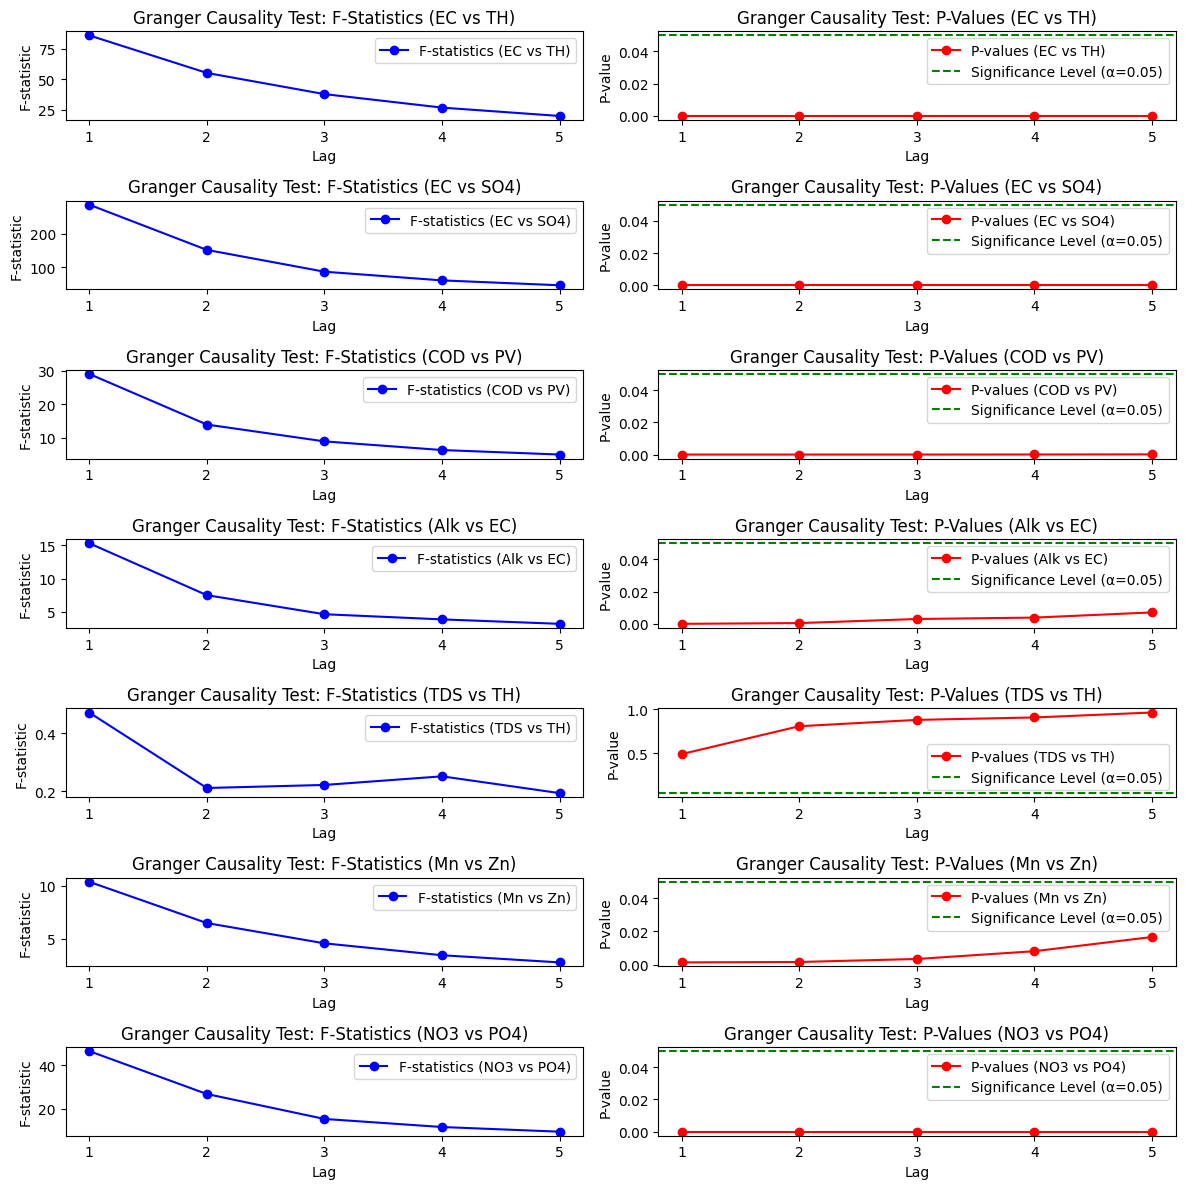

In [20]:
# Define pairs of parameters to analyze
parameter_pairs = [
    ('EC', 'TH'),
    ('EC', 'SO4'),
    ('COD', 'PV'),
    ('Alk', 'EC'),
    ('TDS', 'TH'),
    ('Mn', 'Zn'),
    ('NO3', 'PO4')
]

max_lag = 5  # Set the maximum lag to test

# Create a figure for subplots
plt.figure(figsize=(12, 12))

for idx, (param1, param2) in enumerate(parameter_pairs, start=1):
    # Prepare data for the current pair
    test_data = data_filtered[[param1, param2]]
    
    # Perform Granger Causality Test
    test_result = grangercausalitytests(test_data, max_lag, verbose=False)

    # Prepare data for plotting
    lags = range(1, max_lag + 1)
    f_stats = [test_result[i][0]['ssr_ftest'][0] for i in lags]
    p_values = [test_result[i][0]['ssr_ftest'][1] for i in lags]

    # F-statistics subplot
    plt.subplot(len(parameter_pairs), 2, (idx - 1) * 2 + 1)
    plt.plot(lags, f_stats, marker='o', label=f'F-statistics ({param1} vs {param2})', color='b')
    plt.title(f'Granger Causality Test: F-Statistics ({param1} vs {param2})')
    plt.xlabel('Lag')
    plt.ylabel('F-statistic')
    plt.xticks(lags)
    plt.legend()

    # P-values subplot
    plt.subplot(len(parameter_pairs), 2, (idx - 1) * 2 + 2)
    plt.plot(lags, p_values, marker='o', label=f'P-values ({param1} vs {param2})', color='r')
    plt.axhline(y=0.05, color='g', linestyle='--', label='Significance Level (α=0.05)')
    plt.title(f'Granger Causality Test: P-Values ({param1} vs {param2})')
    plt.xlabel('Lag')
    plt.ylabel('P-value')
    plt.xticks(lags)
    plt.legend()

# Adjust layout and save the plot
plt.tight_layout()
#plt.savefig('granger_causality_test_results_multiple_pairs.png')
#plt.close()
plt.show()

plot for the the reverse pairs also.

c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functio

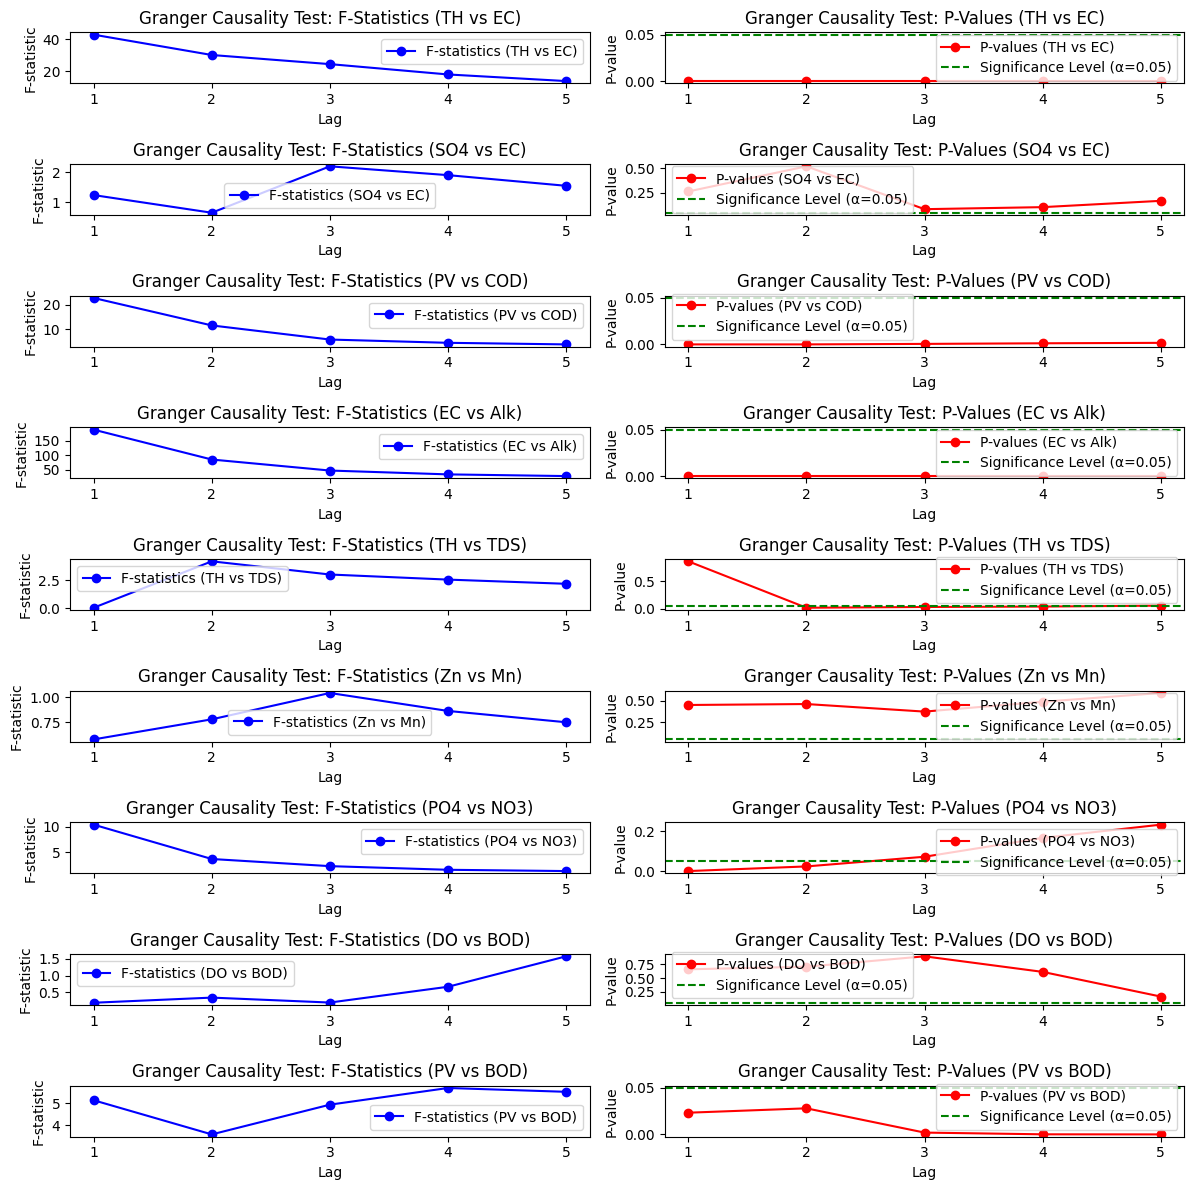

In [24]:
max_lag = 5  # Set the maximum lag to test

# Create a figure for subplots
plt.figure(figsize=(12, 12))

for idx, (param1, param2) in enumerate(parameter_pairs_reverse, start=1):
    # Prepare data for the current pair
    test_data = data_filtered[[param1, param2]]
    
    # Perform Granger Causality Test
    test_result = grangercausalitytests(test_data, max_lag, verbose=False)

    # Prepare data for plotting
    lags = range(1, max_lag + 1)
    f_stats = [test_result[i][0]['ssr_ftest'][0] for i in lags]
    p_values = [test_result[i][0]['ssr_ftest'][1] for i in lags]

    # F-statistics subplot
    plt.subplot(len(parameter_pairs_reverse), 2, (idx - 1) * 2 + 1)
    plt.plot(lags, f_stats, marker='o', label=f'F-statistics ({param1} vs {param2})', color='b')
    plt.title(f'Granger Causality Test: F-Statistics ({param1} vs {param2})')
    plt.xlabel('Lag')
    plt.ylabel('F-statistic')
    plt.xticks(lags)
    plt.legend()

    # P-values subplot
    plt.subplot(len(parameter_pairs_reverse), 2, (idx - 1) * 2 + 2)
    plt.plot(lags, p_values, marker='o', label=f'P-values ({param1} vs {param2})', color='r')
    plt.axhline(y=0.05, color='g', linestyle='--', label='Significance Level (α=0.05)')
    plt.title(f'Granger Causality Test: P-Values ({param1} vs {param2})')
    plt.xlabel('Lag')
    plt.ylabel('P-value')
    plt.xticks(lags)
    plt.legend()

# Adjust layout and save the plot
plt.tight_layout()
#plt.savefig('granger_causality_test_results_reverse_pairs.png')
#plt.close()
plt.show()

Performing the kruskal wallis test to check for any significant differences within catchments(for all parameters). This also reveals if geographical location affects these parameters. 

Null Hypothesis (H0): There are no significant differences between Catchments.

Alternative Hypothesis (HA): There is at least one significant difference between Catchments.

test for unlimited parameters.

In [7]:
# Extract the parameter columns from the dataset
parameters = data.columns[6:]

catchment_groups = {}
results = {}

# Perform the Kruskal-Wallis test for each parameter
for parameter in parameters:
    if parameter in unlimited_parameters:
        catchment_groups[parameter] = []
        groups = []
        catchment_names = []  # List to store catchment names
        for catchment, group in data.groupby('Catchment'):
            values = group[parameter].dropna().values
            catchment_groups[parameter].append(values)
            groups.append(values)
            catchment_names.append(catchment)  # Add catchment name

        statistic, p_value = kruskal(*groups)
        results[parameter] = (statistic, p_value)

        # Perform pairwise Dunn's test
        pairwise_results = posthoc_dunn(groups, p_adjust='bonferroni')
        pairwise_results.index = catchment_names  # Set catchment names as index
        pairwise_results.columns = catchment_names  # Set catchment names as column names
        results[parameter] = (statistic, p_value, pairwise_results)

# Print the test statistics, p-values, and pairwise results
print("Kruskal-Wallis and Pairwise Dunn's Test Results:")
for parameter, (statistic, p_value, pairwise_results) in results.items():
    print(f"Parameter: {parameter}")
    print("Test statistic:", statistic)
    print("p-value:", p_value)
    print("Pairwise results:")
    print(pairwise_results)
    print()

Kruskal-Wallis and Pairwise Dunn's Test Results:
Parameter: BOD
Test statistic: 166.33665377472286
p-value: 2.6901918707247135e-33
Pairwise results:
                  Gwayi       Manyame        Mazowe     Mzingwane  \
Gwayi      1.000000e+00  8.995708e-03  1.418916e-26  1.352000e-11   
Manyame    8.995708e-03  1.000000e+00  7.135370e-16  5.055296e-04   
Mazowe     1.418916e-26  7.135370e-16  1.000000e+00  3.892260e-03   
Mzingwane  1.352000e-11  5.055296e-04  3.892260e-03  1.000000e+00   
Runde      1.351612e-17  3.321435e-08  2.625768e-01  1.000000e+00   
Sanyati    1.650829e-14  1.622117e-06  1.000000e+00  1.000000e+00   
Save       2.016537e-09  2.165193e-02  2.743485e-06  1.000000e+00   

                  Runde       Sanyati          Save  
Gwayi      1.351612e-17  1.650829e-14  2.016537e-09  
Manyame    3.321435e-08  1.622117e-06  2.165193e-02  
Mazowe     2.625768e-01  1.000000e+00  2.743485e-06  
Mzingwane  1.000000e+00  1.000000e+00  1.000000e+00  
Runde      1.000000e+00  1.0

In [8]:
import pandas as pd
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from scikit_posthocs import posthoc_dunn

# Extract the parameter columns from the dataset
parameters = data.columns[6:]

catchment_groups = {}
results = {}

# Perform the Kruskal-Wallis test for each parameter
for parameter in parameters:
    if parameter in unlimited_parameters:
        catchment_groups[parameter] = []
        groups = []
        catchment_names = []  # List to store catchment names
        for catchment, group in data.groupby('Catchment'):
            values = group[parameter].dropna().values
            catchment_groups[parameter].append(values)
            groups.append(values)
            catchment_names.append(catchment)  # Add catchment name

        statistic, p_value = kruskal(*groups)
        
        # Perform pairwise Dunn's test
        pairwise_results = posthoc_dunn(groups, p_adjust='bonferroni')
        pairwise_results.index = catchment_names  # Set catchment names as index
        pairwise_results.columns = catchment_names  # Set catchment names as column names
        
        # Save results in the dictionary
        results[parameter] = (statistic, p_value, pairwise_results)

# Prepare results for CSV
output_data = []
for parameter, (statistic, p_value, pairwise_results) in results.items():
    # Flatten pairwise results for CSV
    for i, catchment1 in enumerate(catchment_names):
        for j, catchment2 in enumerate(catchment_names):
            if i < j:  # Avoid duplicates and self-comparisons
                output_data.append({
                    'Parameter': parameter,
                    'Catchment1': catchment1,
                    'Catchment2': catchment2,
                    'Statistic': statistic,
                    'p-value': p_value,
                    'Pairwise Result': pairwise_results.loc[catchment1, catchment2]
                })

# Create a DataFrame from the output data
results_df = pd.DataFrame(output_data)

# Save to CSV
results_df.to_csv('kruskal_wallis_results.csv', index=False)

print("Results saved to 'kruskal_wallis_results.csv'.")

Results saved to 'kruskal_wallis_results.csv'.


For limited.

In [26]:
# Filter the data for years less than 2017
filtered_data = data[data['Year'] < 2017]

# Perform the Kruskal-Wallis test for each parameter
for parameter in parameters:
    if parameter in limited_parameters:  # Apply condition for limited parameters
        catchment_groups[parameter] = []
        groups = []
        catchment_names = []  # List to store catchment names
        for catchment, group in filtered_data.groupby('Catchment'):
            values = group[parameter].dropna().values
            catchment_groups[parameter].append(values)
            groups.append(values)
            catchment_names.append(catchment)  # Add catchment name

        if len(groups) > 1:  # Ensure there are multiple groups to compare
            statistic, p_value = kruskal(*groups)
            # Store results
            results[parameter] = (statistic, p_value)

            # Perform pairwise Dunn's test
            pairwise_results = posthoc_dunn(groups, p_adjust='bonferroni')
            pairwise_results.index = catchment_names  # Set catchment names as index
            pairwise_results.columns = catchment_names  # Set catchment names as column names
            results[parameter] = (statistic, p_value, pairwise_results)

# Print the test statistics, p-values, and pairwise results
print("Kruskal-Wallis and Pairwise Dunn's Test Results:")
for parameter, (statistic, p_value, pairwise_results) in results.items():
    print(f"Parameter: {parameter}")
    print("Test statistic:", statistic)
    print("p-value:", p_value)
    print("Pairwise results:")
    print(pairwise_results)
    print()

Kruskal-Wallis and Pairwise Dunn's Test Results:
Parameter: BOD
Test statistic: 166.33665377472286
p-value: 2.6901918707247135e-33
Pairwise results:
                  Gwayi       Manyame        Mazowe     Mzingwane  \
Gwayi      1.000000e+00  8.995708e-03  1.418916e-26  1.352000e-11   
Manyame    8.995708e-03  1.000000e+00  7.135370e-16  5.055296e-04   
Mazowe     1.418916e-26  7.135370e-16  1.000000e+00  3.892260e-03   
Mzingwane  1.352000e-11  5.055296e-04  3.892260e-03  1.000000e+00   
Runde      1.351612e-17  3.321435e-08  2.625768e-01  1.000000e+00   
Sanyati    1.650829e-14  1.622117e-06  1.000000e+00  1.000000e+00   
Save       2.016537e-09  2.165193e-02  2.743485e-06  1.000000e+00   

                  Runde       Sanyati          Save  
Gwayi      1.351612e-17  1.650829e-14  2.016537e-09  
Manyame    3.321435e-08  1.622117e-06  2.165193e-02  
Mazowe     2.625768e-01  1.000000e+00  2.743485e-06  
Mzingwane  1.000000e+00  1.000000e+00  1.000000e+00  
Runde      1.000000e+00  1.0

Time series analysis, trend, seasonality.

Just edit Accordingly.

Values over time.

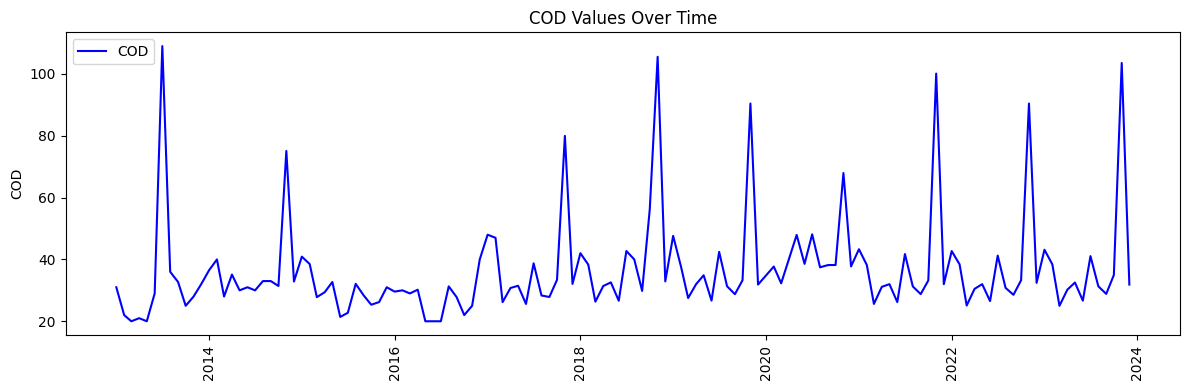

In [29]:
parameter = "COD"

# Filter data based on whether the parameter is limited
if parameter in limited_parameters:
    data_filtered = data[data['Year'] < 2017]
else:
    data_filtered = data

# Compute median DO across all catchments by year and month
averages = data_filtered.groupby(['Year', 'Month'])[parameter].median().reset_index()

# Prepare datetime for plotting
averages['Year'] = averages['Year'].astype(str)
averages['Month'] = pd.Categorical(averages['Month'], categories=calendar.month_name[1:], ordered=True)
averages.sort_values(['Year', 'Month'], inplace=True)
averages['Month'] = averages['Month'].astype(str)
averages['Date'] = pd.to_datetime(averages['Year'] + averages['Month'], format='%Y%B')

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 4))

# Plot median DO over time
ax.plot(averages['Date'], averages[parameter], label=parameter, color='blue')
ax.set_ylabel(parameter)
ax.set_title(f'{parameter} Values Over Time')
ax.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


ACF and PACF plots.

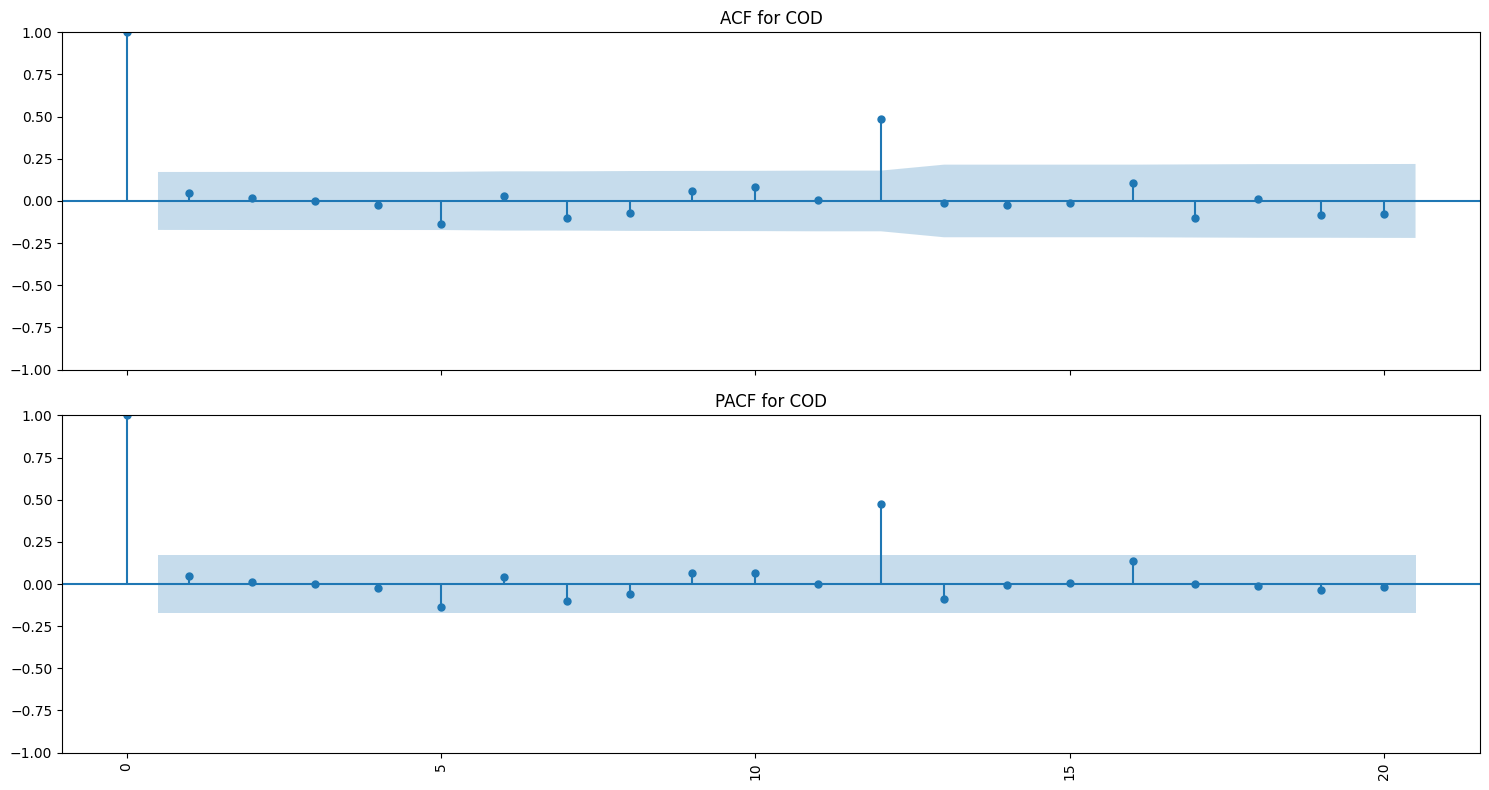

In [30]:
# Group and preprocess data
averages = data.groupby(['Year', 'Month'])[parameter].median().reset_index()

# Convert Year and Month to strings
averages['Year'] = averages['Year'].astype(str)
averages['Month'] = pd.Categorical(averages['Month'], categories=calendar.month_name[1:], ordered=True)

# Sort the data
averages.sort_values(['Year', 'Month'], inplace=True)
averages['Month'] = averages['Month'].astype(str)

# Create a datetime column
averages['Date'] = pd.to_datetime(averages['Year'] + averages['Month'], format='%Y%B')

# ---------------------- Step 1: ACF and PACF for pH ----------------------------
fig, ax = plt.subplots(nrows=2, figsize=(15, 8), sharex=True)

plot_acf(averages[parameter], ax=ax[0], lags=20, title=f'ACF for {parameter}')
plot_pacf(averages[parameter], ax=ax[1], lags=20, title=f'PACF for {parameter}')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Trend and Seasonality.

c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\BIGSAM TECH\AppData\Local\Programs\Python\Python310\lib\site-pac

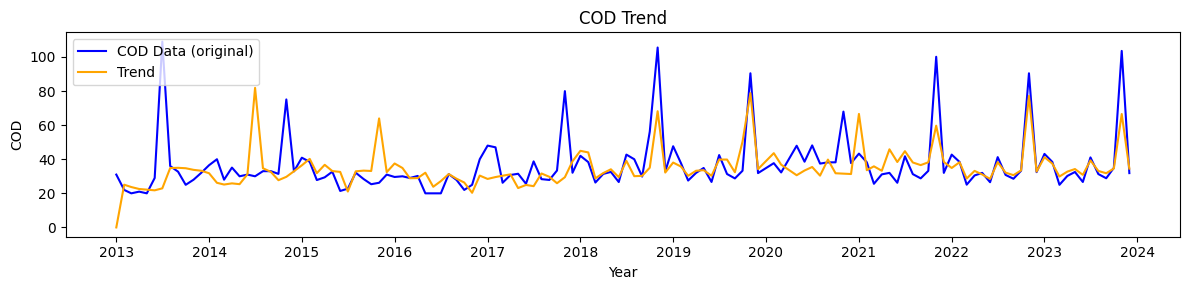

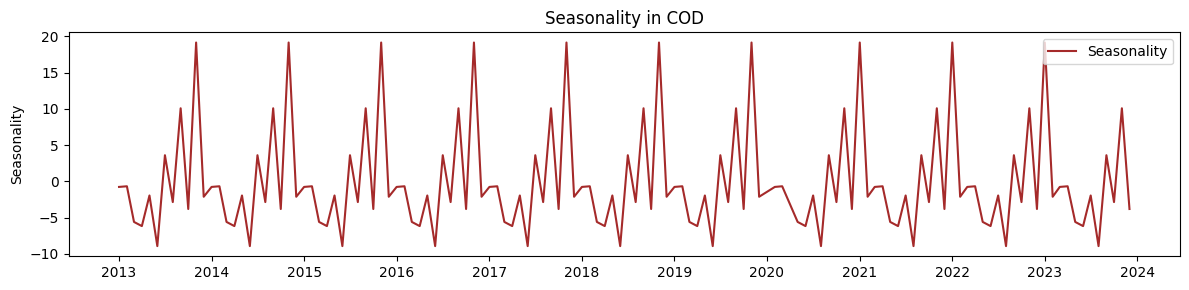

In [40]:
# Fit model e.g SARIMA(1,0,1)(0,0,1,12) or arima
model = SARIMAX(averages[parameter], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit()

# Generate in-sample predictions
averages['Forecast'] = model_fit.predict(start=0, end=len(averages)-1)

# Plot actual DO data vs SARIMA forecast
plt.figure(figsize=(12, 3))
plt.plot(averages['Date'], averages[parameter], label=f'{parameter} Data (original)', color='blue')
plt.plot(averages['Date'], averages['Forecast'], label='Trend', color='orange')
plt.xlabel('Year')
plt.ylabel(f'{parameter}')
plt.title(f'{parameter} Trend')
plt.legend()

# Format x-axis to show only years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

# ---------------------- Step 3: Seasonality ----------------------------
# Seasonal decomposition of interpolated DO data
decomposition = seasonal_decompose(averages[parameter], model='additive', period=12)

plt.figure(figsize=(12, 3))
plt.plot(averages['Date'], decomposition.seasonal, label='Seasonality', color='brown')
plt.ylabel('Seasonality')
plt.title(f'Seasonality in {parameter}')
plt.legend()

# Format x-axis to show only years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


Looking at catchment level

C:\Users\BIGSAM TECH\AppData\Local\Temp\ipykernel_11820\3310620939.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catchment_data['Month'] = catchment_data['Month'].astype(str)
C:\Users\BIGSAM TECH\AppData\Local\Temp\ipykernel_11820\3310620939.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catchment_data['Month'] = catchment_data['Month'].astype(str)
C:\Users\BIGSAM TECH\AppData\Local\Temp\ipykernel_11820\3310620939.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

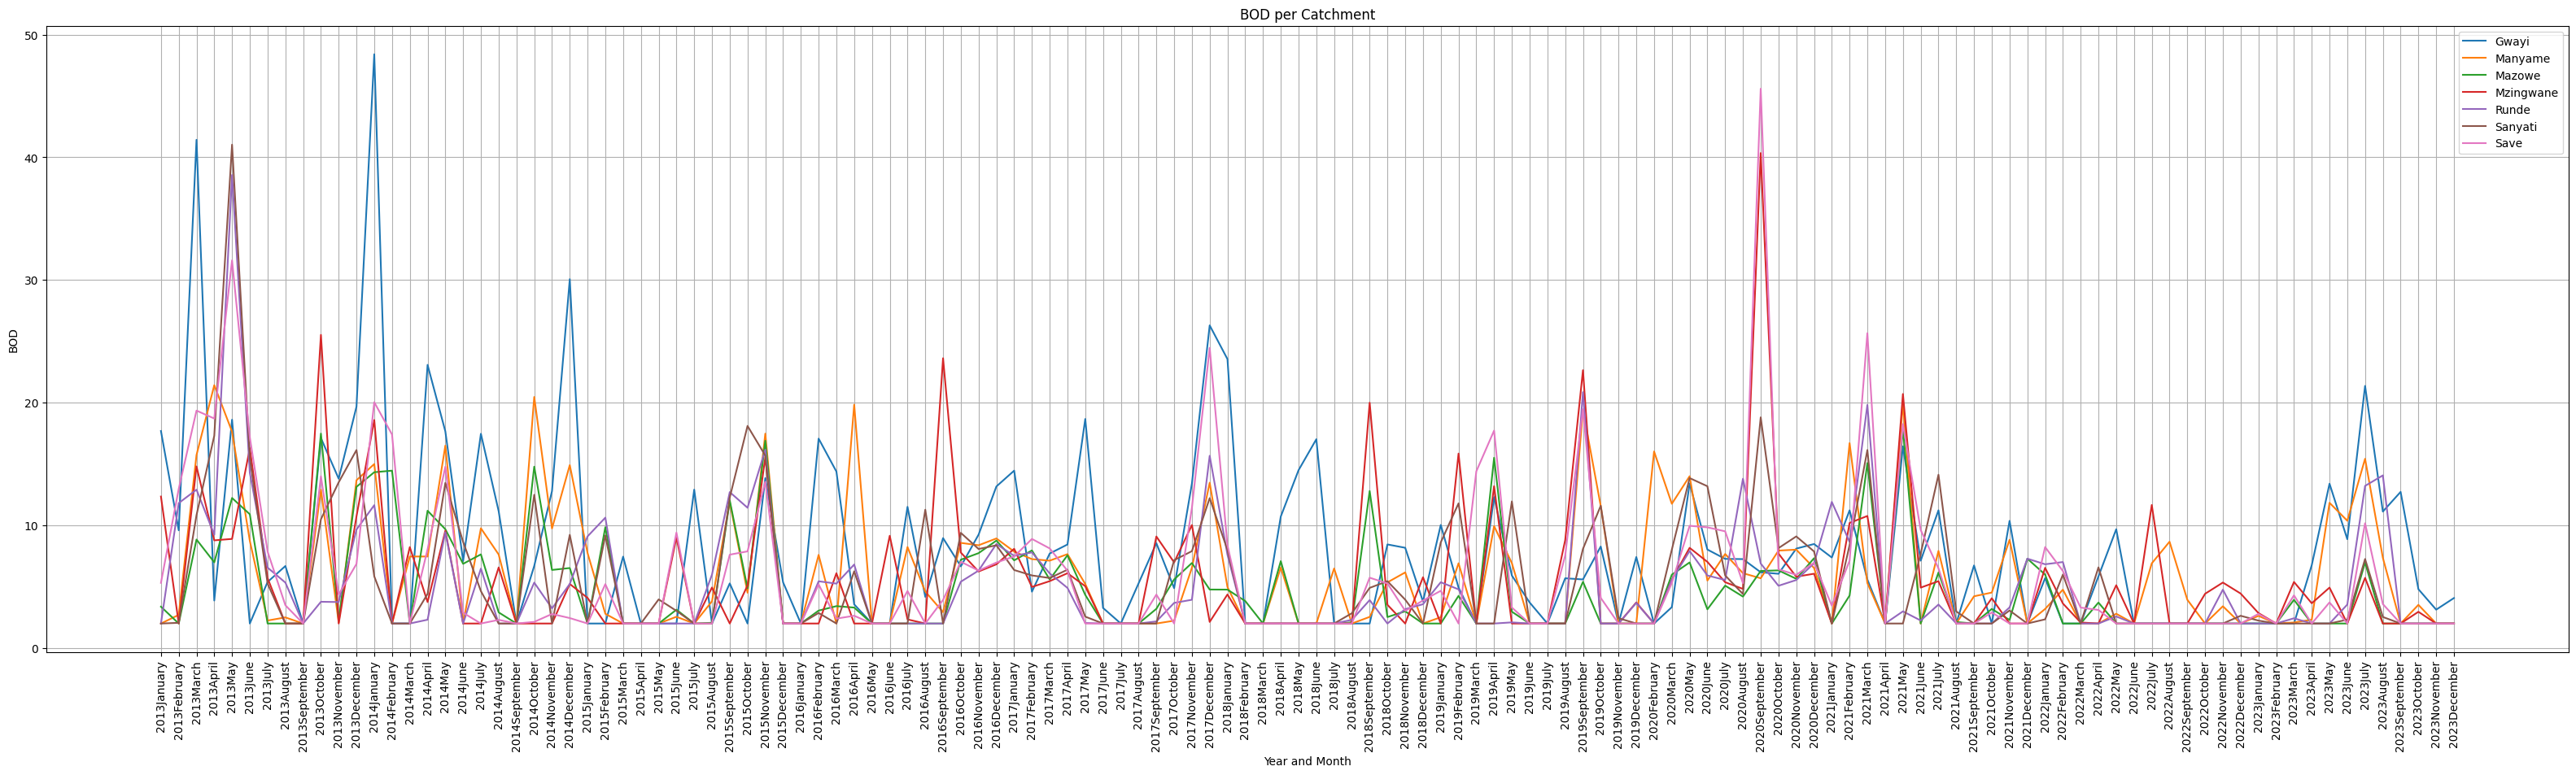

In [40]:
# Calculate the average for each catchment, month, and year.
averages_catch = data_filtered.groupby(['Catchment', 'Year', 'Month'])[parameter].median().reset_index()

# Convert Year and Month to strings before concatenating
averages_catch['Year'] = averages_catch['Year'].astype(str)

# Convert Month to categorical with default month order
averages_catch['Month'] = pd.Categorical(averages_catch['Month'], categories=calendar.month_name[1:], ordered=True)

# Sort the data by Year, Month, and Catchment
averages_catch.sort_values(['Year', 'Month', 'Catchment'], inplace=True)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(40, 10))

# Iterate over each catchment
for catchment in averages_catch['Catchment'].unique():
    # Filter the data for the current catchment
    catchment_data = averages_catch[averages_catch['Catchment'] == catchment]

    # Convert Month to strings for concatenation
    catchment_data['Month'] = catchment_data['Month'].astype(str)

    # Plot the line graph for the catchment
    ax.plot(catchment_data['Year'] + catchment_data['Month'],
            catchment_data[parameter], label=catchment)

# Add labels and title
ax.set_xlabel('Year and Month')
ax.set_ylabel(parameter)
ax.set_title(f'{parameter} per Catchment')

# Add a legend
ax.legend()

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

plt.grid(True)

# Show the plot for the current parameter
plt.show()

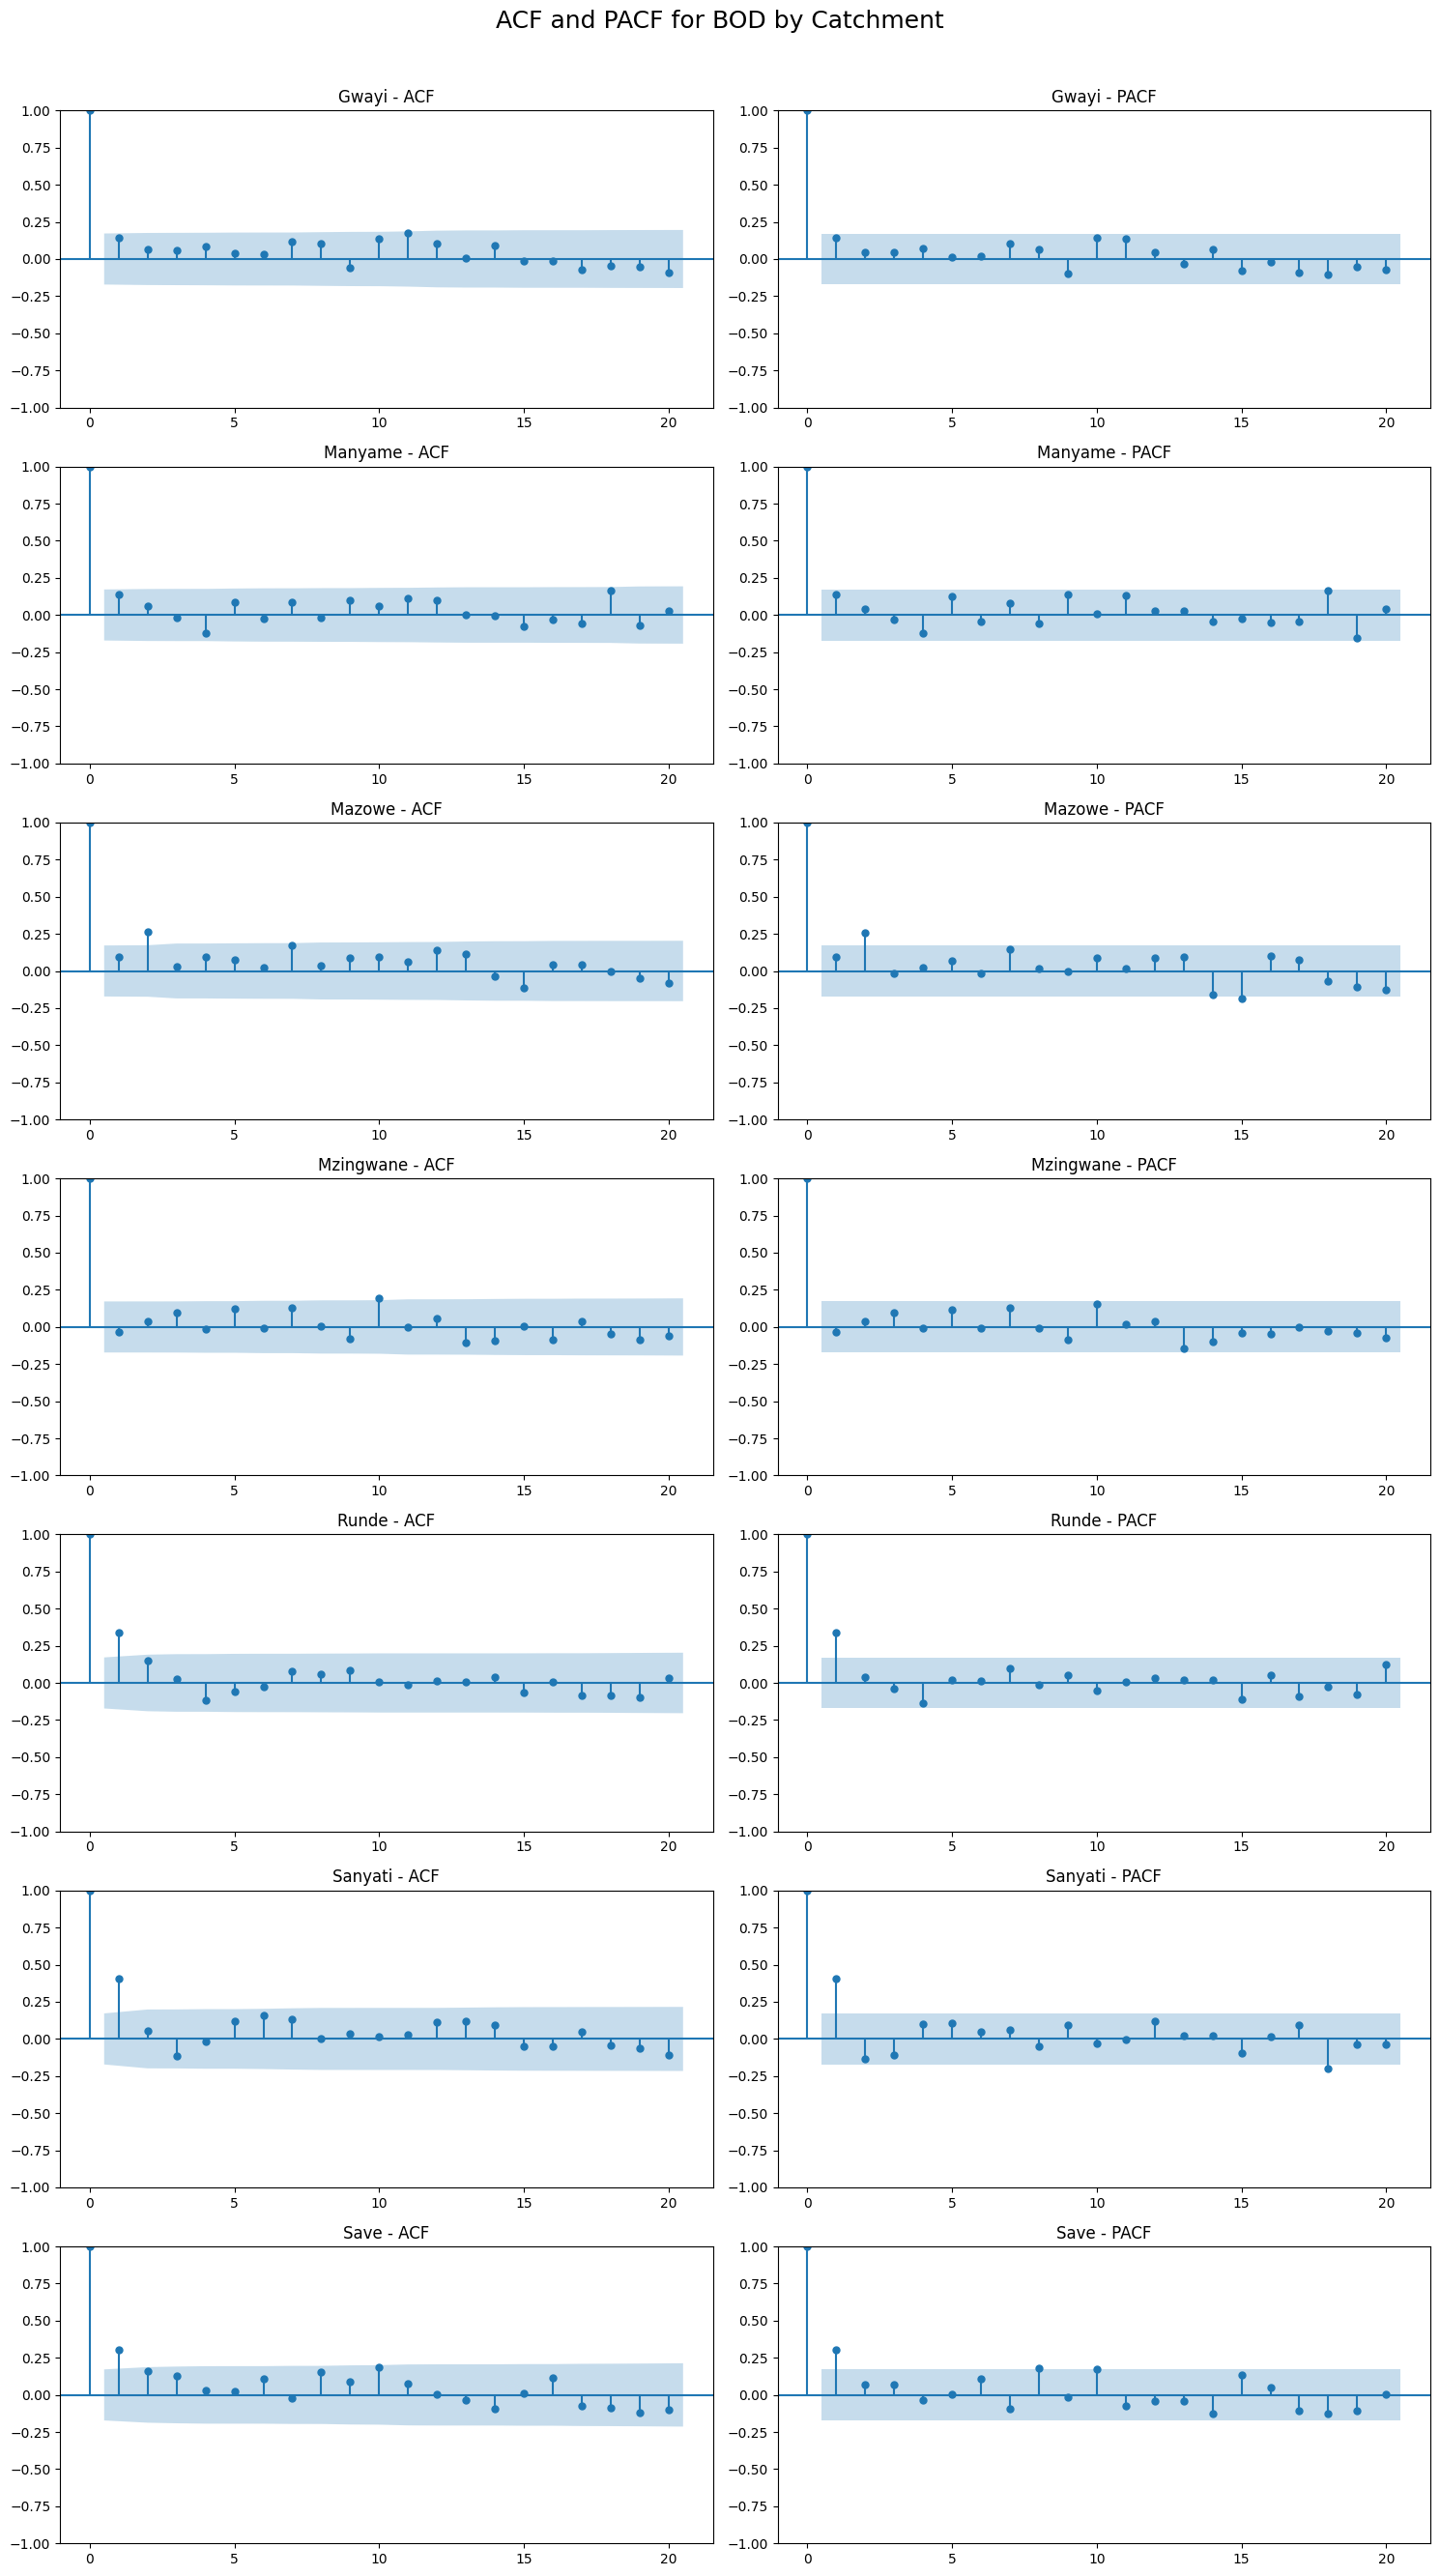

In [41]:
# Group by Catchment, Year, and Month, and calculate median
grouped = data.groupby(['Catchment', 'Year', 'Month'])[parameter].median().reset_index()

# Convert Year and Month to strings
grouped['Year'] = grouped['Year'].astype(str)
grouped['Month'] = pd.Categorical(grouped['Month'], categories=calendar.month_name[1:], ordered=True)
grouped.sort_values(['Catchment', 'Year', 'Month'], inplace=True)
grouped['Month'] = grouped['Month'].astype(str)

# Prepare list of unique catchments
catchments = grouped['Catchment'].unique()
num_catchments = len(catchments)

# Create a figure large enough to hold subplots
fig, axes = plt.subplots(nrows=num_catchments, ncols=2, figsize=(15, 4 * num_catchments))
fig.suptitle(f'ACF and PACF for {parameter} by Catchment', fontsize=18)

# Loop through catchments and create ACF/PACF subplots
for i, catchment in enumerate(catchments):
    catchment_data = grouped[grouped['Catchment'] == catchment].copy()
    catchment_data['Date'] = pd.to_datetime(catchment_data['Year'] + catchment_data['Month'], format='%Y%B')

    if len(catchment_data) < 20:
        continue

    # ACF
    plot_acf(catchment_data[parameter], ax=axes[i, 0], lags=20)
    axes[i, 0].set_title(f'{catchment} - ACF')

    # PACF
    plot_pacf(catchment_data[parameter], ax=axes[i, 1], lags=20)
    axes[i, 1].set_title(f'{catchment} - PACF')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


C:\Users\BIGSAM TECH\AppData\Local\Temp\ipykernel_11820\636696381.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(catchments))


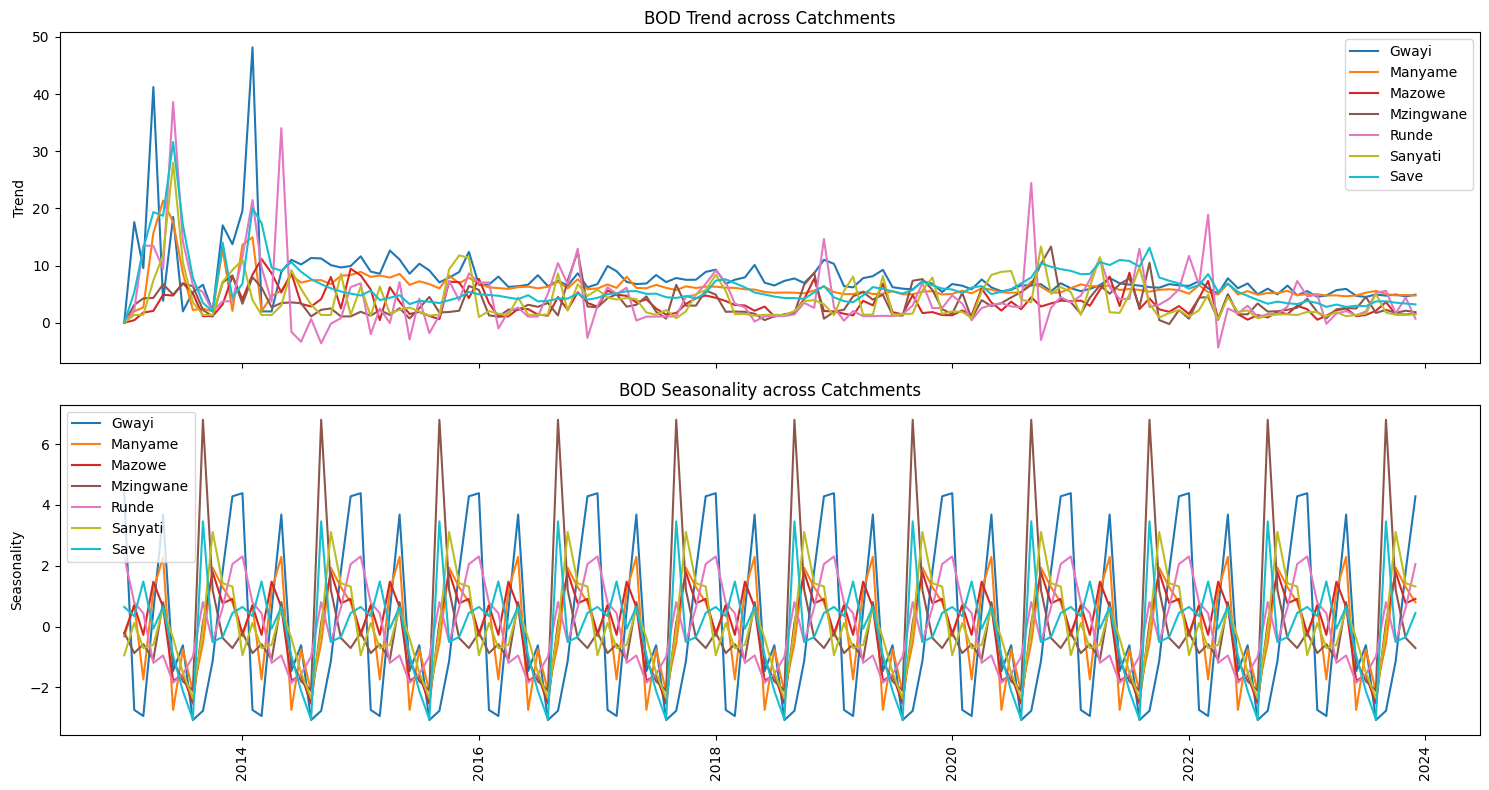

In [69]:
# SARIMA orders for each catchment based on ACF/PACF plots
sarima_orders = {
    'Gwayi': ((1, 0, 1), (0, 0, 1, 12)),
    'Manyame': ((1, 0, 1), (0,0, 1, 12)),
    'Mazowe': ((2, 0, 0), (1, 0, 1, 12)),
    'Mzingwane': ((2, 0, 0), (0, 0, 1, 12)),
    'Runde': ((1, 1, 1), (0, 1, 0, 12)),
    'Sanyati': ((1, 0, 0), (0, 0, 1, 12)),
    'Save': ((0, 1, 1), (0, 0, 1, 12))
}

# Define ARIMA orders for each catchment
#arima_orders = {
#    'Gwayi': (1, 0, 1),
#   'Mzingwane': (2, 1, 0),
#    'Runde': (1, 1, 2),
#    'Save': (0, 1, 1),
#    'Manyame': (1, 0, 1),
#    'Mazowe': (2, 0, 1),
#    'Sanyati': (1, 1, 0)
#}

# Compute monthly medians per catchment
averages = data_filtered.groupby(['Catchment', 'Year', 'Month'])[parameter].median().reset_index()
averages['Year'] = averages['Year'].astype(str)
averages['Month'] = pd.Categorical(averages['Month'], categories=calendar.month_name[1:], ordered=True)
averages.sort_values(['Catchment', 'Year', 'Month'], inplace=True)
averages['Month'] = averages['Month'].astype(str)

# Set up subplots
fig, ax = plt.subplots(nrows=2, figsize=(15, 8), sharex=True)

# Define color palette
catchments = averages['Catchment'].unique()
colors = plt.cm.get_cmap('tab10', len(catchments))

# Loop through catchments
for i, catchment in enumerate(catchments):
    catchment_data = averages[averages['Catchment'] == catchment].copy()

    # Combine year and month into a datetime
    catchment_data['Date'] = pd.to_datetime(catchment_data['Year'] + catchment_data['Month'], format='%Y%B')

    # Create a complete date range and merge
    full_dates = pd.date_range(start=catchment_data['Date'].min(), end=catchment_data['Date'].max(), freq='MS')
    full_df = pd.DataFrame({'Date': full_dates})
    merged = pd.merge(full_df, catchment_data[['Date', parameter]], on='Date', how='left')
    merged[parameter] = merged[parameter].interpolate()

    # Get SARIMA order
    order, seasonal_order = sarima_orders.get(catchment, ((1, 0, 0), (0, 0, 0, 12)))

    # Fit SARIMA model
    model = SARIMAX(merged[parameter], order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    # Use fitted values as trend
    merged['Trend'] = model_fit.fittedvalues

    # Decompose to get seasonality
    decomposition = seasonal_decompose(merged[parameter], model='additive', period=12)

    # Plot trend
    ax[0].plot(merged['Date'], merged['Trend'], label=catchment, color=colors(i))

    # Plot seasonality
    ax[1].plot(merged['Date'], decomposition.seasonal, label=catchment, color=colors(i))

# Format plots
ax[0].set_ylabel('Trend')
ax[0].set_title(F'{parameter} Trend across Catchments')
ax[0].legend()

ax[1].set_ylabel('Seasonality')
ax[1].set_title(f'{parameter} Seasonality across Catchments')
ax[1].legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()